In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm

In [33]:
# 定义模型
SEQ_LENGTH = 100 # 序列长度
BATCH_SIZE = 32 # 批大小
FEATURE_SIZE = 7 # 特征数量
N_BLOCK = 2 # 堆叠的块数量
HIDDEN_SIZE = 32 # 隐藏层大小
DROUPOUT = 0.1 # dropout比例
LEARNING_RATE = 0.001 # 学习率
N_HEAD = 2 # 多头注意力机制的头数量
EMBED_SIZE = 32 # 词嵌入大小
TARGET_SIZE = 1 # 目标大小
EPOCH = 20 # 训练轮数

In [34]:
# 加载数据
data = pd.read_csv('train/ETTh1.csv')
print(data.head())
data = data.drop(columns=['date'])
print(data.head())
data

                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
    HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  5.358  1.942  1.492  0.462  3.868  1.279  21.948000


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...
17415,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [35]:
# 数据标准化
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data)
data.shape

(17420, 7)

In [36]:
def split_data(data, seq_length, feature_size, target_size):
    X = []
    Y = []

    for i in range(len(data) - seq_length - target_size + 1):
        x = data.iloc[i:(i + seq_length), :].values
        y = data.iloc[(i + seq_length):(i + seq_length + target_size), :].values
        X.append(x)
        Y.append(y)

    dataX = np.array(X)
    dataY = np.array(Y)

    # 获取训练集大小
    train_size = int(np.round(0.8 * dataX.shape[0]))

    # 划分训练集和测试集
    X_train = dataX[:train_size, :].reshape(-1, seq_length, feature_size)
    Y_train = dataY[:train_size].reshape(-1, target_size, feature_size)

    X_test = dataX[train_size:, :].reshape(-1, seq_length, feature_size)
    Y_test = dataY[train_size:].reshape(-1, target_size, feature_size)

    return X_train, Y_train, X_test, Y_test

In [37]:
# 获取训练集和测试集
trainX, trainY, testX, testY = split_data(data, SEQ_LENGTH, FEATURE_SIZE, TARGET_SIZE)

# 转换为张量
trainX = torch.from_numpy(trainX).to(torch.float32)
trainY = torch.from_numpy(trainY).to(torch.float32)

testX = torch.from_numpy(testX).to(torch.float32)
testY = torch.from_numpy(testY).to(torch.float32)

trainX.shape

torch.Size([13856, 100, 7])

In [38]:
# 形成训练数据集
train_data = TensorDataset(trainX, trainY)
test_data = TensorDataset(testX, testY)

In [39]:
# 生成train_batch test_batch
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
data = next(iter(train_loader))

print(data[0].shape)
print(data[1].shape)
print(data[1].size(1)) 

torch.Size([32, 100, 7])
torch.Size([32, 1, 7])
1


In [40]:
# 定义模型
class Transformer(nn.Module):
    def __init__(self,n_head = N_HEAD, n_block = N_BLOCK, embed_size = EMBED_SIZE, hidden_size = HIDDEN_SIZE, dropout = DROUPOUT, seq_length = SEQ_LENGTH):
        super().__init__()
        # 嵌入层
        self.input_proj = nn.Linear(FEATURE_SIZE, embed_size)
        self.output_proj = nn.Linear(embed_size, FEATURE_SIZE)

        self.position_embed = nn.Parameter(torch.zeros(100, embed_size)) # 位置编码
        nn.init.uniform_(self.position_embed, -0.02, 0.02)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=n_head, dim_feedforward=hidden_size, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_block)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=n_head, dim_feedforward=hidden_size, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_block)

    def forward(self, src, tgt):
        # src: (32, 100, 7)
        # tgt: (32, 1, 7)
        src = self.input_proj(src)
        tgt = self.input_proj(tgt)

        seq_len = tgt.size(1)
        tgt_len = src.size(1)
        src = src + self.position_embed[:seq_len, :].unsqueeze(0)  # [batch_size, seq_length, d_model]
        tgt = tgt + self.position_embed[:tgt_len, :].unsqueeze(0)  # [batch_size, tgt_len, d_model]

        # 将src和tgt转置 维度变为(seq_length, batch_size, d_model)
        src = src.transpose(0, 1)
        tgt = tgt.transpose(0, 1)

        # Encoder
        memory = self.encoder(src)

        # Decoder
        output = self.decoder(tgt, memory)

        # 转置回来
        output = output.transpose(0, 1)

        # 输出层
        output = self.output_proj(output)

        return output

In [41]:
model = Transformer(n_head=N_HEAD, n_block=N_BLOCK, embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, dropout=DROUPOUT, seq_length=SEQ_LENGTH)

d:\python\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [42]:
def compute_accuracy(pred, target, threshold=0.1):
    correct = (torch.abs(pred - target) < threshold).float()
    accuracy = correct.mean().item() * 100
    return accuracy


In [43]:
def plot_loss_curve(losses, EPOCH):
    plt.plot(range(1, EPOCH+1), losses, marker='o', color='b', label='Training Loss')
    plt.title('Training Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [44]:
# 不同阈值下的准确率
def plot_accuracy_vs_threshold(thresholds, accuracies):
    plt.plot(thresholds, accuracies, marker='o', color='b', label='Accuracy vs Threshold')
    plt.title('Accuracy vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [45]:
from sklearn.metrics import mean_squared_error

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 用于记录每个epoch的损失
losses = []

# 训练模型
for epoch in range(EPOCH):
    model.train()
    for src, tgt in train_loader:
        optimizer.zero_grad()

        # 前向传播
        output = model(src, tgt)

        # 计算损失
        loss = 1000 * criterion(output, tgt)

        # 反向传播以及优化
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {epoch+1}/{EPOCH}, Loss: {loss.item()}')

d:\python\anaconda3\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 1, 7])) that is different to the input size (torch.Size([32, 100, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 1.8327003717422485
Epoch 2/20, Loss: 0.7722180485725403
Epoch 3/20, Loss: 0.4976218342781067
Epoch 4/20, Loss: 0.3463882505893707
Epoch 5/20, Loss: 0.3247026801109314
Epoch 6/20, Loss: 0.19536039233207703
Epoch 7/20, Loss: 0.16922052204608917
Epoch 8/20, Loss: 0.18037386238574982
Epoch 9/20, Loss: 0.1153726875782013
Epoch 10/20, Loss: 0.09054159373044968
Epoch 11/20, Loss: 0.06405063718557358
Epoch 12/20, Loss: 0.07088855654001236
Epoch 13/20, Loss: 0.04318270832300186
Epoch 14/20, Loss: 0.03603376820683479
Epoch 15/20, Loss: 0.047080863267183304
Epoch 16/20, Loss: 0.031827881932258606
Epoch 17/20, Loss: 0.0187371838837862
Epoch 18/20, Loss: 0.03962200507521629
Epoch 19/20, Loss: 0.02165059745311737
Epoch 20/20, Loss: 0.019037889316678047


In [46]:
model.eval()
total_loss = 0.0
# 定义阈值范围
thresholds = [i / 1000 for i in range(1, 21)]  # 从 0.001 到 0.02，步长为 0.001
total_accuracy = {threshold: 0.0 for threshold in thresholds}  # 保存不同阈值下的准确率
with torch.no_grad():
    for src, tgt in test_loader:
        tgt_input = tgt[:, :SEQ_LENGTH]  # Ensure tgt has the correct size for decoder input
        pred = model(src, tgt_input)
        
        # Compute loss
        loss = criterion(pred, tgt)
        total_loss += loss.item()
        
        for threshold in thresholds:
            accuracy = compute_accuracy(pred, tgt, threshold)
            total_accuracy[threshold] += accuracy

avg_loss = total_loss / len(test_loader)
avg_accuracy = {threshold: total_accuracy[threshold] / len(test_loader) for threshold in thresholds}
print(f"Test Loss: {avg_loss:.4f}")
for threshold, accuracy in avg_accuracy.items():
    print(f"Threshold {threshold:.3f} - Accuracy: {accuracy:.2f}%")

Test Loss: 0.0000
Threshold 0.001 - Accuracy: 21.66%
Threshold 0.002 - Accuracy: 46.76%
Threshold 0.003 - Accuracy: 69.73%
Threshold 0.004 - Accuracy: 84.72%
Threshold 0.005 - Accuracy: 92.65%
Threshold 0.006 - Accuracy: 96.35%
Threshold 0.007 - Accuracy: 98.42%
Threshold 0.008 - Accuracy: 99.30%
Threshold 0.009 - Accuracy: 99.68%
Threshold 0.010 - Accuracy: 99.83%
Threshold 0.011 - Accuracy: 99.90%
Threshold 0.012 - Accuracy: 99.93%
Threshold 0.013 - Accuracy: 99.94%
Threshold 0.014 - Accuracy: 99.95%
Threshold 0.015 - Accuracy: 99.96%
Threshold 0.016 - Accuracy: 99.98%
Threshold 0.017 - Accuracy: 99.98%
Threshold 0.018 - Accuracy: 99.98%
Threshold 0.019 - Accuracy: 99.99%
Threshold 0.020 - Accuracy: 99.99%


d:\python\anaconda3\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8, 1, 7])) that is different to the input size (torch.Size([8, 100, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


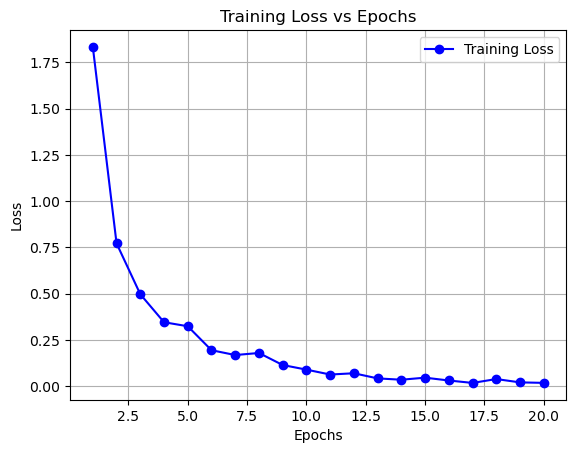

In [47]:
# 可视化迭代损失
plot_loss_curve(losses, EPOCH)

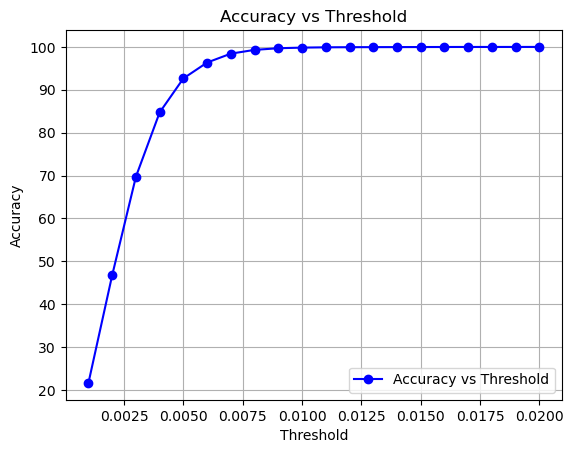

In [48]:
# 可视化不同阈值下的准确率
plot_accuracy_vs_threshold(thresholds, list(avg_accuracy.values()))